## Travel time to regional hubs
Use Mapbox API to calcuate travel time to major neighboring cities (population greater than 1mil).  
Use district centroids as origins

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from shapely.wkt import loads

In [2]:
# paths to data
# pop_file = '/home/public/Data/PROJECTS/infraSAP_URY/origins/ury_ppp_2020_500mts_wgs.shp'
# G_path = '/home/public/Data/PROJECTS/LAC_GOSTNets/graphs/URY/G_URY.pickle'
# global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/Major_Cities.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/global_settlement_points_v1_01_gt50000.shp'
iso = 'ARG'
data_dir = f'/home/public/Data/PROJECTS/INFRA_SAP/{iso}'
raster_path = os.path.join(data_dir, 'WP_2020_1km.tif')
output_path = os.path.join(os.path.expanduser("~"),'data/argentina')
target = gpd.read_file(os.path.join(data_dir, 'admin.shp'))
urban_extents = os.path.join(data_dir, 'urban_extents.shp')

# target = gpd.read_file('/home/public/Data/PROJECTS/LAC_GOSTNets/g2015_2014_2_LAC.shp')
# target = target[target['ADM0_NAME'] == 'Uruguay'].reset_index(drop=True)
# OD = pd.read_csv(os.path.join(output_path, 'ODs', 'OD_04_14.csv'), header=[0,1], index_col=0)

In [3]:
target['centroid'] = target.centroid

In [4]:
cities = gpd.read_file(global_cities)

In [6]:
# border_countries = ['Chile', 'Bolivia', 'Uruguay', 'Brazil', 'Paraguay']

In [7]:
cities_filter = cities.copy()
# cities_filter = cities[cities.Country.isin(border_countries)].copy()
cities_filter = cities_filter[cities_filter.Pop>1000000].copy()

In [8]:
cities_filter = cities_filter.to_crs('EPSG:3857')
target = target.to_crs('EPSG:3857')

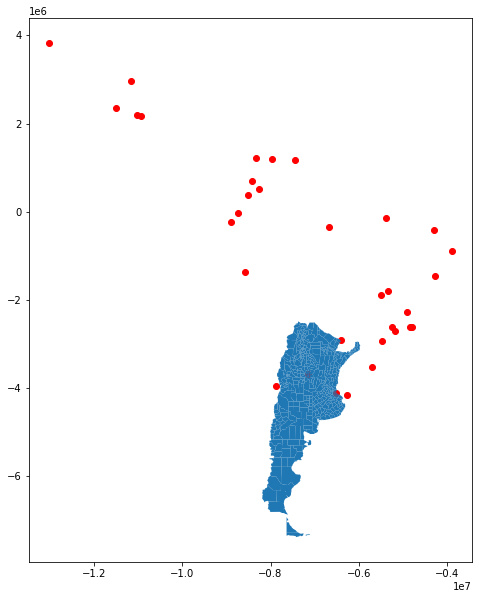

In [9]:
ax = cities_filter.plot(figsize=(10, 10), color='red')
target.plot(figsize=(10, 10), ax=ax)

In [10]:
arg = target.dissolve(by='WB_ADM0_CO')

In [21]:
cities_filter = cities_filter.loc[~cities_filter.intersects(arg.geometry.iloc[0])]

In [23]:
arg = target.dissolve(by='WB_ADM0_CO')
cities_filter['dist_to_ARG'] = cities_filter.distance(arg.centroid.iloc[0])
cities_filter = cities_filter.sort_values('dist_to_ARG')

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
output_path

'/home/wb514197/data/argentina'

In [11]:
# cities_filter.to_csv(os.path.join(output_path, 'cities_filter.csv'))

In [25]:
cities_filter = cities_filter.head(10).to_crs(cities.crs)

In [26]:
target = target.to_crs(cities.crs)

In [27]:
target.crs == cities_filter.crs

True

In [28]:
origins = target.copy()
dests = cities_filter.copy().reset_index(drop=True)

In [29]:
origins['x'] = origins.centroid.x
origins['y'] = origins.centroid.y

In [30]:
dests['x'] = dests.geometry.x
dests['y'] = dests.geometry.y

In [31]:
origins['ID'] = origins.OBJECTID
dests['ID'] = dests.index

In [32]:
origins_sel = origins.loc[:,["ID","x","y"]].copy()
dests_sel = dests.loc[:,["ID","x","y"]].copy()

In [33]:
origins_sel['Pop'] = 1
dests_sel['Pop'] = 1

In [34]:
os.getcwd()

'/home/wb514197/scripts/argentina'

In [35]:
origins_sel.to_csv("origins.csv")
dests_sel.to_csv("dests.csv")

In [36]:
import json, sys, os, time, argparse, logging
import shapely

import pandas as pd
import numpy as np
import urllib.request as url

In [37]:
MB_Toke = '' # create a Mapbox account and get it from your profile page

In [38]:
def CreateODMatrix(infile, infile_2, lat_name = 'Lat', lon_name = 'Lon', UID = 'ID', 
                    Pop = 'Pop', call_type = 'OSRM', rescue = 0, rescue_num = 0, MB_Toke = '', 
                    sleepTime = 5, osrmHeader = ''):
    '''
    TODO: make the function flexible for MapBox endpoint - add back MB token / different formatting
    '''
    ffpath = os.path.dirname(infile)
    start = time.time()
    print('\nChosen server: %s\n\nStart time: %s' % (call_type, time.ctime(start)))
    print('Origins: %s' % infile)
    print('Destinations: %s\n' % infile_2)

    # Save settings
    save_rate = 5
    def save(returns, j, i, numcalls, rescue_num):
        elapsed_mins = (time.time() - start)/60
        elapsed_secs = (time.time() - start)%60
        total = ((numcalls / float(i)) * (time.time() - start)/60.0)
        remaining = total - elapsed_mins
        print ('\n______________________________________\n')
        print ('\nSave point %s. Running for: %d minutes %d seconds' % (j, elapsed_mins, elapsed_secs))
        print ('\ncalls completed: %d of %d. Est. run time: %d minutes. Time remaining: %d' % (i-1, numcalls, total, remaining))
        print ('\npercentage complete: %d percent' % (((i-1) / float(numcalls)*100)))
        print ('\n______________________________________\n')
        try:
            df = pd.concat(returns)
        except:
            df = returns
        curOutput = os.path.join(ffpath,'temp_file_%d.csv' % rescue_num)
        df.to_csv(curOutput)
        
        
    # Function for calling OSRM server.
    def Call(O_list, D_list, i, O_IDs, D_IDs, header):
        # Convert origins to HTTP request string
        Os = ';'.join(str(coord).replace("'", "").replace(";", "") for coord in O_list)
        # Destinations to HTTP request string
        Ds = ';'.join(str(coord).replace("'", "").replace(";", "") for coord in D_list)
        # Join them together
        data = Os+';'+Ds

        # Define which coords in data string are origins, and which are destinations
        sources = ['%d' % x for x in range(0,len(O_list))]
        sources = ';'.join(str(x).replace("'", "") for x in sources)
        lenth = len(O_list)+len(D_list)
        destinations = ['%d' % x for x in range(len(O_list),lenth)]
        destinations = ';'.join(str(x).replace("'", "") for x in destinations)

        # Build request string
        request = header+data+'?sources='+sources+'&destinations='+destinations+'?&access_token='+MB_Toke
        # Pass request to interweb
        
        try:
            r = url.urlopen(request)
        except:
            print(request)
            time.sleep(5)
            r = url.urlopen(request)
            
        # Error handle
        try:
            # Convert Bytes response to readable Json
            MB_TelTest_json = json.loads(r.read().decode('utf-8'))
            data_block = MB_TelTest_json['durations']
        except:
            data_block = 'null'

        # Build df from JSON
        #sources_label = [str(i['location']) for i in MB_TelTest_json['sources']]
        #dest_label = [str(i['location']) for i in MB_TelTest_json['destinations']]
        sources_label = O_IDs
        dest_label = D_IDs
        chunk = pd.DataFrame(data = data_block, columns = dest_label, index = sources_label)
        # Convert to minutes, stack 2D array to 1D array
        chunk = chunk.stack(level =-1)
        chunk.columns = ['O','D','DIST']
        return(chunk)

    # Generate appropriately split source and destination lists
    def split_and_bundle(in_list,break_size):
        new_list = []
        for i in range (0,(int(max(len(in_list)/break_size,1)))):
            upper = (i+1) * break_size
            lower = (upper - break_size)
            objs = in_list[lower:upper]
            new_list.append(objs)
        if len(in_list) > break_size:
            rem = len(in_list) % break_size
            if rem > 0:
                final = upper+rem
                new_list.append(in_list[upper:final])
        return new_list

    # File Import for sources file
    input_df = pd.read_csv(infile)
    input_df['source_list'] = input_df[lon_name].map(str).str.cat(input_df[lat_name].map(str), sep = ',')
    input_df['source_list'] = input_df['source_list']+';'
    source_list = input_df['source_list'].values.tolist()
    source_UIDs = input_df[UID].values.tolist()
    #input_df['source_point'] = input_df.apply(lambda x: Point(x[lon_name],x[lat_name]), axis = 1)
    #source_points = input_df['source_point'].tolist()

    # Look to import separate file for destinations; if not, set destinations = sources
    input_df2 = pd.read_csv(infile_2)
    input_df2['dest_list'] =  input_df2[lon_name].map(str).str.cat(input_df2[lat_name].map(str), sep = ',')
    input_df2['dest_list'] = input_df2['dest_list']+';'
    dest_list = input_df2['dest_list'].values.tolist()
    dest_UIDs = input_df2[UID].values.tolist()           

    if call_type == 'MBT' :
        sources_list = split_and_bundle(source_list, 5)
        dests_list = split_and_bundle(dest_list, 5)
        sources_UIDs = split_and_bundle(source_UIDs, 5)
        dests_UIDs = split_and_bundle(dest_UIDs, 5)
    elif call_type == 'MB'or call_type == 'OSRM':
        sources_list = split_and_bundle(source_list, 12)
        dests_list = split_and_bundle(dest_list, 13)
        sources_UIDs = split_and_bundle(source_UIDs, 12)
        dests_UIDs = split_and_bundle(dest_UIDs, 13)
    else:
        pass
            
    # Run function call across the O-D matrix; output is 'df'
    returns = []
    numcalls = (len(sources_list) * len(dests_list))
    s , d = sources_list, dests_list
    i, j = 1 + (rescue * len(sources_list)), 1 + rescue

    ### Making Calls 
    if call_type == 'Euclid':
        df = EuclidCall(source_list,dest_list,source_points,dest_points)
    else:
        if rescue > 0:
            s = s[rescue:] # possibly rescue -1
            sources_UIDs = sources_UIDs[rescue:]
        print('source list: %s' % len(source_list))
        print('sources list: %s' % len(sources_list))
        print('dest list: %s' % len(dest_list))
        print('dests list: %s' % len(dests_list))
        numcalls_rem = (len(s) * len(d))
        print('\nEstimated remaining calls to chosen server: %d\n' % numcalls_rem)
        print('save points will occur every %d calls\n' % (len(dests_list)))
        if sleepTime > 0:
            time.sleep(sleepTime)
        for O_list in s:
            O_IDs = sources_UIDs[s.index(O_list)]
            for D_list in d:                    
                if sleepTime > 0:
                    time.sleep(sleepTime)
                D_IDs = dests_UIDs[d.index(D_list)]
                if call_type == 'MB':
                    header = 'https://api.mapbox.com/directions-matrix/v1/mapbox/driving/'
                elif call_type == 'MBT':
                    header = 'https://api.mapbox.com/directions-matrix/v1/mapbox/driving-traffic/'
                elif call_type == 'OSRM':
                    header = 'http://router.project-osrm.org/table/v1/driving/'
                    if osrmHeader != '':
                        header = osrmHeader
                try:
                    # prevent server annoyance
                    print('Call to OSRM server number: %d of %s' % (i, numcalls_rem))                
                    returns.append(Call(O_list,D_list,i,O_IDs,D_IDs, header))
                    i += 1
                    j += 1
                except:
                    logging.warning("Error Processing OSRM for i:%s and j:%s" % (i, j))
                    save(returns, j, i, numcalls, rescue_num)
        try:
            df = pd.concat(returns)
        except:
            df = returns

    # re-attach the population of origins and destinations, prep dataframe
    all_matrices = []
    if rescue_num > 0:
        for r in range(0,rescue_num):
            rescued_matrix = pd.read_csv(os.path.join(ffpath,'temp_file_%d.csv' % (r)),header=None)
            rescued_matrix.columns = ['O_UID','D_UID','DIST']
            all_matrices.append(rescued_matrix)
    df = df.reset_index()
    df.columns = ['O_UID','D_UID','DIST']
    all_matrices.append(df)
    new = pd.concat(all_matrices)
    try:
        new = new.set_index('O_UID')
        new['DIST'] = new['DIST'].apply(pd.to_numeric)
        popdf = input_df[[UID,Pop]].set_index(UID)
        new['O_POP'] = popdf[Pop]
        new = new.reset_index()
        new = new.set_index('D_UID')
        if dest_list == source_list:
            new['D_POP'] = popdf[Pop]
            new = new.reset_index()
        else:
            popdf_dest = input_df2[[UID,Pop]].set_index(UID)
            new['D_POP'] = popdf_dest[Pop]
            new = new.reset_index()
        new['O_UID'] = new['O_UID'].astype(str)
        new['D_UID'] = new['D_UID'].astype(str)
        new['combo'] = new['O_UID']+'_X_'+new['D_UID']
        new = new.drop_duplicates('combo')
        new = new.drop(['combo'], axis = 1)

        return new
    except:
        print("Something went wrong with processing population information, returning results without population results")
        return new

In [39]:
odRes = CreateODMatrix('origins.csv', 'dests.csv', lat_name = 'y', lon_name = 'x', UID = 'ID', 
                    Pop = 'Pop', call_type = 'MB', rescue = 0, rescue_num = 0, MB_Toke = 'pk.eyJ1IjoiZmVyY2hvc2lsdmEiLCJhIjoiY2s0MDM3c3IzMGNmMTNqbndza21vNXVxbiJ9.ap8UNe_LwH8IBgO0SnT1fA', 
                    sleepTime = 5, osrmHeader = '')


Chosen server: MB

Start time: Tue Jun  9 15:31:30 2020
Origins: origins.csv
Destinations: dests.csv

source list: 513
sources list: 43
dest list: 10
dests list: 1

Estimated remaining calls to chosen server: 43

save points will occur every 1 calls

Call to OSRM server number: 1 of 43
Call to OSRM server number: 2 of 43
Call to OSRM server number: 3 of 43
Call to OSRM server number: 4 of 43
Call to OSRM server number: 5 of 43
Call to OSRM server number: 6 of 43
Call to OSRM server number: 7 of 43
Call to OSRM server number: 8 of 43
Call to OSRM server number: 9 of 43
Call to OSRM server number: 10 of 43
Call to OSRM server number: 11 of 43
Call to OSRM server number: 12 of 43
Call to OSRM server number: 13 of 43
Call to OSRM server number: 14 of 43
Call to OSRM server number: 15 of 43
Call to OSRM server number: 16 of 43
Call to OSRM server number: 17 of 43
Call to OSRM server number: 18 of 43
Call to OSRM server number: 19 of 43
Call to OSRM server number: 20 of 43
Call to OSRM serv

In [40]:
odRes

,D_UID,O_UID,DIST,O_POP,D_POP
0,0,2517,58514.7,1,1
1,1,2517,25422.1,1,1
2,2,2517,59273.0,1,1
3,3,2517,58472.2,1,1
4,4,2517,90101.3,1,1
...,...,...,...,...,...
5125,5,3029,112792.3,1,1
5126,6,3029,112384.8,1,1
5127,7,3029,130189.8,1,1
5128,8,3029,132269.3,1,1


In [41]:
OD_re = odRes.pivot(index='O_UID',columns='D_UID', values='DIST')

In [42]:
OD_re.head()

D_UID,0,1,2,3,4,5,6,7,8,9
O_UID,,,,,,,,,,
2517,58514.7,25422.1,59273.0,58472.2,90101.3,110313.1,111740.5,127710.6,129790.1,135794.6
2518,55918.9,24841.2,58692.1,57891.3,89520.4,109732.2,111159.6,127129.7,129209.2,135213.7
2519,56133.0,38656.4,72507.3,71706.5,103335.6,123547.4,124974.8,140944.9,143024.4,149028.9
2520,65914.9,31043.5,67501.4,66700.6,98329.7,118541.5,119968.9,135939.0,138018.5,144023.0
2521,55368.6,21241.4,55092.3,54291.5,85920.6,106132.4,107559.8,123529.9,125609.4,131613.9


In [43]:
OD_re2 = OD_re.apply(lambda x: x/(60*60))

In [44]:
OD_re2.head()

D_UID,0,1,2,3,4,5,6,7,8,9
O_UID,,,,,,,,,,
2517,16.254083,7.061694,16.464722,16.242278,25.028139,30.642528,31.039028,35.475167,36.052806,37.720722
2518,15.533028,6.900333,16.303361,16.080917,24.866778,30.481167,30.877667,35.313806,35.891444,37.559361
2519,15.592500,10.737889,20.140917,19.918472,28.704333,34.318722,34.715222,39.151361,39.729000,41.396917
2520,18.309694,8.623194,18.750389,18.527944,27.313806,32.928194,33.324694,37.760833,38.338472,40.006389
2521,15.380167,5.900389,15.303417,15.080972,23.866833,29.481222,29.877722,34.313861,34.891500,36.559417


In [45]:
output_path

'/home/wb514197/data/argentina'

In [46]:
os.getcwd()

'/home/wb514197/scripts/argentina'

In [47]:
OD_re2.to_csv(os.path.join(output_path,"OD_RegionalHubs.csv"))

In [48]:
OD_re3 = pd.DataFrame(OD_re2.idxmin(axis=1), columns=['ID']).join(pd.DataFrame(OD_re2.min(axis=1), columns=['tt_regional']))
# OD_re3 = pd.DataFrame(data=[OD_re2.idxmin(axis=1), OD_re2.min(axis=1)], index=['D_UID','time']).transpose()

In [49]:
OD_re3.head()

,ID,tt_regional
O_UID,,
2517,1,7.061694
2518,1,6.900333
2519,1,10.737889
2520,1,8.623194
2521,1,5.900389


In [50]:
OD_re3['OBJECTID'] = OD_re3.index.astype('int')

In [51]:
target_hubs = target.merge(OD_re3, on='OBJECTID')

In [52]:
len(target_hubs)

513

In [53]:
dests['ID'] = dests.ID.astype('int')

In [54]:
target_hubs['ID'] = target_hubs['ID'].astype('int')

In [55]:
dests.columns

Index(['DN', 'ID_clst', 'id_ue_ntl', 'Area_km2', 'iduentlAMv', 'ORIG_FID',
       'Name', 'Pop', 'geometry', 'dist_to_ARG', 'x', 'y', 'ID'],
      dtype='object')

In [56]:
target_hubs2 = target_hubs.merge(dests[['Name','ID']], on='ID')

In [57]:
len(target_hubs), len(target_hubs2)

(513, 513)

In [58]:
target_hubs2['Name'].value_counts()

Montevideo    236
Asunci�_n     169
Santiago      108
Name: Name, dtype: int64

In [ ]:
# target_hubs.drop(['GID_0', 'NAME_0','VARNAME_2', 'NL_NAME_1', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2','geometry'], axis=1, inplace=True)

In [59]:
target_hubs2.columns

Index(['OBJECTID', 'ISO_A2', 'WB_ADM1_CO', 'WB_ADM0_CO', 'WB_ADM0_NA',
       'WB_ADM1_NA', 'WB_ADM2_CO', 'WB_ADM2_NA', 'Shape_Leng', 'Shape_Area',
       'ISO3', 'geometry', 'centroid', 'ID', 'tt_regional', 'Name'],
      dtype='object')

In [60]:
target_hubs2.drop(['geometry','Shape_Leng','Shape_Area'], axis=1, inplace=True)

In [61]:
# target_hubs.to_csv(os.path.join(output_path,'tables',"Travel time to regional hub.csv"))

In [62]:
target_hubs2.to_csv(os.path.join(output_path,"TT_RegionalHub.csv"))